In [21]:
# Importing necessary libraries
import pandas as pd
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt

In [22]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category = FutureWarning)
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category = FutureWarning)

Importing dataset and splitting train and test data

In [39]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv')
# print(df.columns)
df.head()
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Data Preprocessing: Oversampling


In [40]:
# For installing imblearn library
#conda install -c conda-forge imbalanced-learn
#sudo pip install imbalanced-learn

from imblearn.over_sampling import SMOTE
from collections import Counter
from numpy import where

# Data oversampling using SMOTE
# summarize class distribution before oversampling
counter = Counter(y_train)
print(counter)

# transform the dataset for oversampling
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y_train)
print(counter)


Counter({0: 166, 1: 73})
Counter({0: 166, 1: 166})


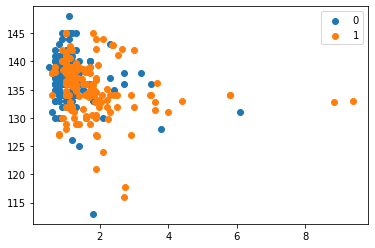

In [25]:
# scatter plot after upsampling: serum creatinine vs sodium
for label, _ in counter.items():
    row_ix = where(y_train == label)[0]
    plt.scatter(X_train[row_ix, 7], X_train[row_ix, 8], label=str(label))
plt.legend()
plt.show()

Importing libraries for models

In [26]:
# import 7 classifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB


Choosing Candidate Models

In [27]:
models = [LogisticRegression(),
          RandomForestClassifier(),
          SVC(),
          DecisionTreeClassifier(),
          MLPClassifier(
                        solver='lbfgs',
                        alpha=1e-5,
                        hidden_layer_sizes=(13,10,5),
                        random_state=1,
                        max_iter=300),
          GradientBoostingClassifier(random_state=0),
          GaussianNB()
          ]

names, values = list(), list()

Importing libraries for Scaling and model evaluation

In [28]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer

In [29]:
# evaluate a model
def evaluate_model(X_train, y_train, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation metric, F2_score
    ftwo_scorer = make_scorer(fbeta_score, beta=2)
    # evaluate model
    scores = cross_val_score(model, X_train, y_train, scoring=ftwo_scorer, cv=cv, n_jobs=-1)
    return scores


Model Evaluation based on F2-score

>Log 0.845 (0.060)
>Ran 0.902 (0.046)
>SVC 0.883 (0.045)
>Dec 0.806 (0.077)
>MLP 0.834 (0.061)
>Gra 0.888 (0.056)
>Gau 0.846 (0.064)


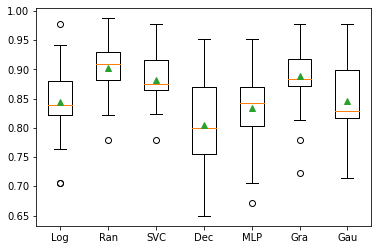

In [30]:
# evaluate each model
for model in models:
    # get a name for the model (First 3 characters)
    name = type(model).__name__[:3]
    # create a pipeline
    pip = Pipeline(steps=[('t1', MinMaxScaler()), ('t2', PowerTransformer()),('m',model)])
    # evaluate the model and store results
    scores = evaluate_model(X_train, y_train, pip)
    # summarize and score
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    names.append(name)
    values.append(scores)
# plot the results
plt.boxplot(values, labels=names, showmeans=True)
plt.show()

Testing Best Model: Random Forest Classifier

Importing few more packages for evaluation

In [31]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [32]:
from numpy import arange
from numpy import argmax

Setting pipeline to fit the best model:

    Step 1: Scaling
    Step 2: Normalizing
    Step 3: Fitting model

In [33]:
#For testing the best model
model = Pipeline(steps=[('t1', MinMaxScaler()),
						('t2', PowerTransformer()),
						('m',RandomForestClassifier(criterion="gini"))])
model.fit(X_train, y_train)

yhat = model.predict_proba(X_test)

y_hat = yhat[:, 1]

Best Threshold Selection based on PR-curve

Best Threshold=0.330000, F2-Score=0.917


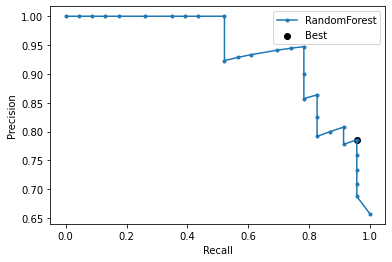

In [34]:
precision, recall, thr = precision_recall_curve(y_test, y_hat)
# convert to f2 score
f2score = (5 * precision * recall) / ((4*precision) + recall)
# locate the index of the largest f2 score
idx = argmax(f2score)
print('Best Threshold=%f, F2-Score=%.3f' % (thr[idx], f2score[idx]))
plt.plot(recall, precision, marker='.', label='RandomForest')
plt.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

Optimal Threshold Selection

In [35]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

In [36]:
# Optimal threshold tuning
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [fbeta_score(y_test, to_labels(y_hat, t), beta = 2) for t in thresholds]

# get best threshold
idx = argmax(scores)
print('Optimal threshold: %.3f' % thresholds[idx])


Optimal threshold: 0.311


Final Score for Model Testing

In [37]:
class_label = to_labels(y_hat, thresholds[idx])
fone_score = f1_score(y_test, class_label)
ftwo_score = scores[idx]
recall = recall_score(y_test, class_label)
precision = precision_score(y_test, class_label)
print('Recall: %.3f' % recall)
print('Precision: %.3f' % precision)
print('F1-Score: %.3f' % fone_score)
print('F2-Score: %.3f' % ftwo_score)

Recall: 0.957
Precision: 0.786
F1-Score: 0.863
F2-Score: 0.917


Relevant Feature Selection

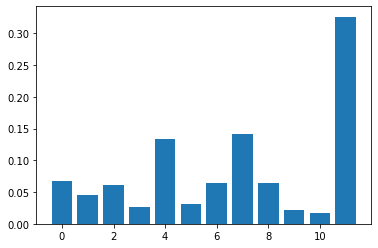

In [38]:
# get importance (higher the better)
importance = model.named_steps['m'].feature_importances_
#print(importance)
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

